In this notebook we run a 3 layer CNN deblender and analyze the results 

In [1]:
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import division
scripts = os.path.join(os.path.dirname(os.getcwd()), "scripts")
sys.path.insert(0, scripts)
import basic_net_utils as utils

In [60]:
out_dir = '/global/cscratch1/sd/sowmyak/'
fname = os.path.join(out_dir, 'training_data',
                         'central_gal_catalog.fits')
cat= Table.read(fname)

In [9]:
def load_data(filename):
    train_data = np.load(filename)
    X_train = train_data['X_train']
    Y_train = train_data['Y_train']
    X_val = train_data['X_val']
    Y_val = train_data['Y_val']
    return X_train, Y_train, X_val, Y_val


def save_diff_blend(pred, Y_val):
    path = os.path.join(os.path.dirname(os.getcwd()), "data")
    filename = os.path.join(path, 'diff')
    diff = (Y_val - pred)
    diff_val =np.sum(np.sum(diff[:,:,:,0], axis=1), axis=1)
    np.save(filename, diff_val)
    return diff_val


from matplotlib.colors import LogNorm
def get_rgb(im):
    min_val = [np.min(im[:,:,i]) for i in range(3)]
    new_im = [im[:,:,i] + np.abs(min_val[i]) for i in range(3)]
    norm = np.max(new_im)
    new_im = [new_im[i].T/norm * 255 for i in range(3)]
    new_im = np.array(new_im, dtype='u1')
    return new_im.T

def plot_preds(pred, X_val, Y_val):
    for num in range(0, 30):
        plt.figure(figsize=[10, 6])
        plt.subplot(5, 5, 1)
        color_im = get_rgb(X_val[num, :, :, :])
        plt.imshow(color_im,norm=LogNorm(vmin=0, vmax=np.max(color_im)-3*np.std(color_im)))
        plt.title('Input blend (g, r, i)')
        plt.subplot(5, 5, 2)
        plt.imshow(X_val[num, :, :, 0])
        plt.colorbar()
        plt.title('Input blend (i)')
        plt.subplot(5, 5, 3)
        plt.imshow(Y_val[num, :, :, 0])
        plt.title('Truth central galaxy (i)')
        plt.colorbar()
        plt.subplot(5, 5, 4)
        plt.imshow(pred[num, :, :, 0])
        plt.colorbar()
        plt.title('Network output')
        plt.subplot(5, 5, 5)
        plt.imshow(Y_val[num, :, :, 0]- pred[num, :, :, 0])
        plt.colorbar()
        plt.title('Truth - output')
        plt.show()


('Train data input shape: ', (22500, 32, 32, 3))
('Train data output shape: ', (22500, 32, 32, 1))
('Validation data input shape: ', (2500, 32, 32, 3))
('Validation data output  shape: ', (2500, 32, 32, 1))


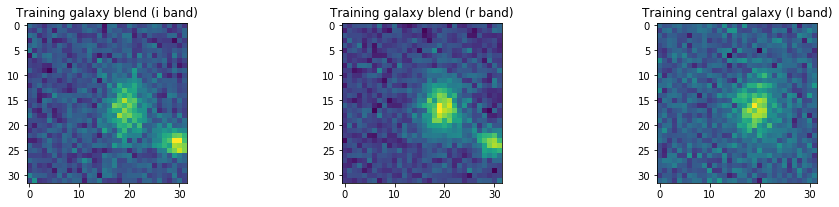

In [3]:
run_ident = 'test_3filter'

# Load data
path = os.path.join(os.path.dirname(os.getcwd()), "data")
filename = os.path.join(path, 'training_data.npz')
X_train, Y_train, X_val, Y_val = load_data(filename)
print('Train data input shape: ', X_train.shape)
print('Train data output shape: ', Y_train.shape)
print('Validation data input shape: ', X_val.shape)
print('Validation data output  shape: ', Y_val.shape)
plt.figure(figsize=[16,10])
plt.subplot(3,3,1)
plt.imshow(X_train[0,:,:,0])
plt.title('Training galaxy blend (i band)')
plt.subplot(3,3,2)
plt.imshow(X_train[0,:,:,1])
plt.title('Training galaxy blend (r band)')
plt.subplot(3,3,3)
plt.imshow(Y_train[0,:,:, 0])
plt.title('Training central galaxy (I band)')

In [4]:
# Load CNN deblender
model = utils.CNN_deblender(run_ident=run_ident)

# Run model
run_params = utils.Meas_args(epochs=10, batch_size=64)
train_loss, val_loss, pred = model.run_basic(X_train, Y_train,
                                             run_params, X_val, Y_val)
model.save()
model.sess.close()

Iteration 0: with minibatch training loss = 8.24443054199
Iteration 100: with minibatch training loss = 1.64229476452
Iteration 200: with minibatch training loss = 1.36589646339
Iteration 300: with minibatch training loss = 1.93533563614
Iteration 400: with minibatch training loss = 1.49790883064
Iteration 500: with minibatch training loss = 1.61559438705
Iteration 600: with minibatch training loss = 1.40831363201
Iteration 700: with minibatch training loss = 1.50056695938
Iteration 800: with minibatch training loss = 1.56572079659
Iteration 900: with minibatch training loss = 1.74452638626
Iteration 1000: with minibatch training loss = 1.67820930481
Iteration 1100: with minibatch training loss = 1.55960583687
Iteration 1200: with minibatch training loss = 1.58694636822
Iteration 1300: with minibatch training loss = 1.26388311386
Iteration 1400: with minibatch training loss = 1.27272152901
Iteration 1500: with minibatch training loss = 1.26786911488
Iteration 1600: with minibatch train

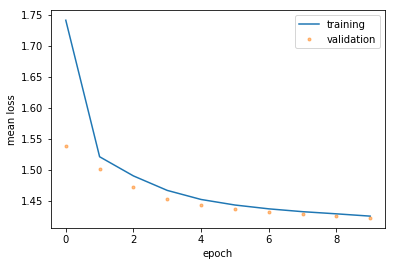

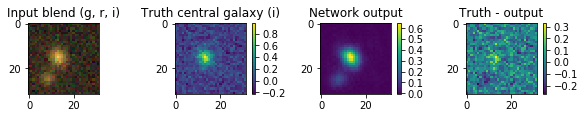

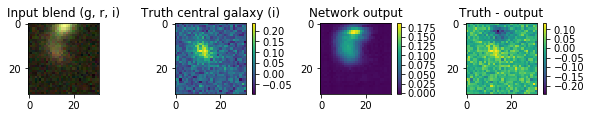

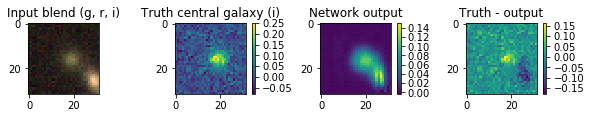

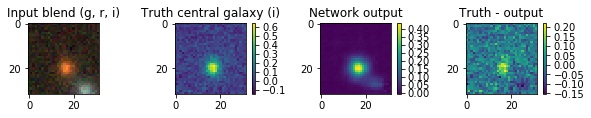

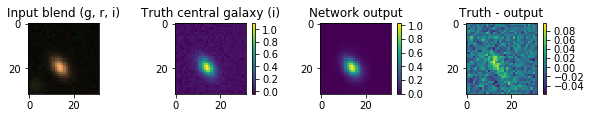

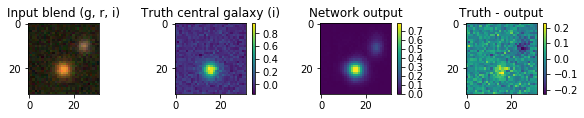

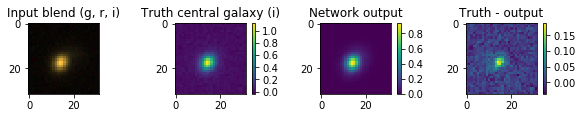

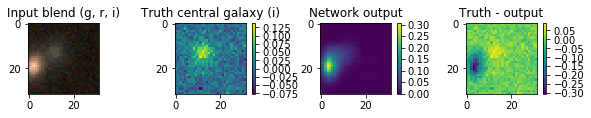

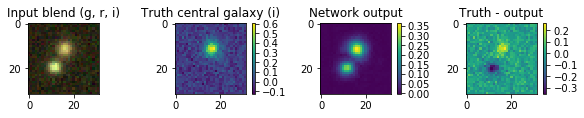

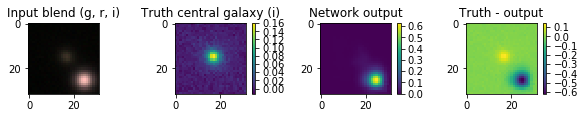

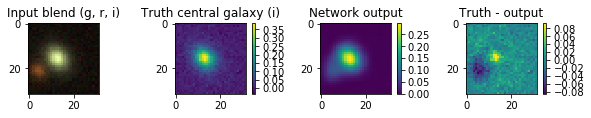

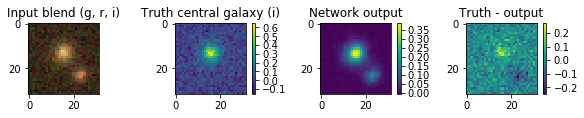

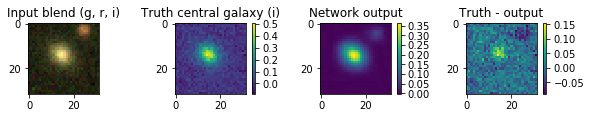

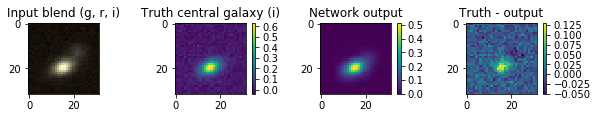

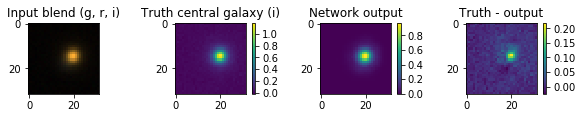

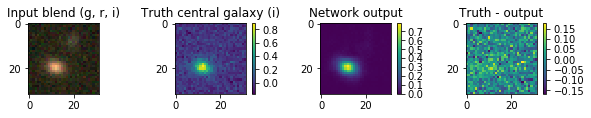

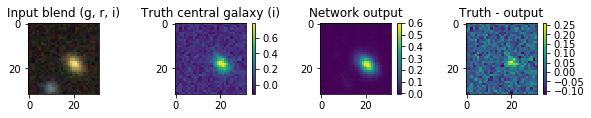

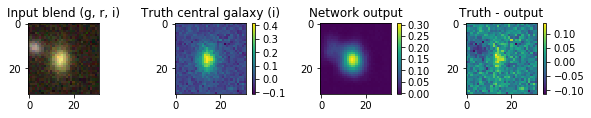

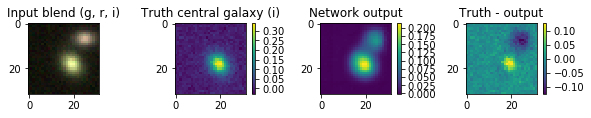

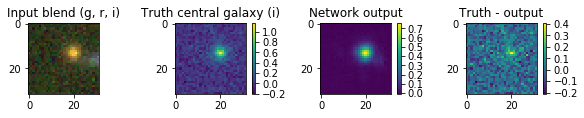

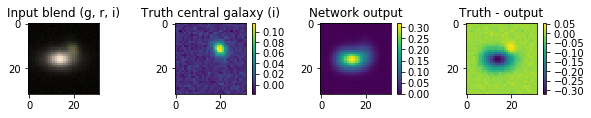

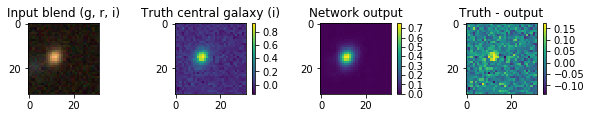

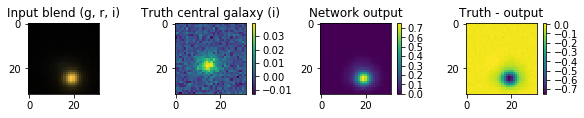

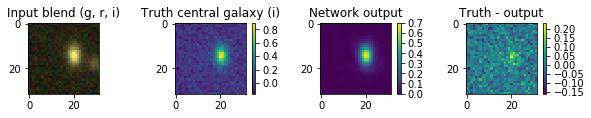

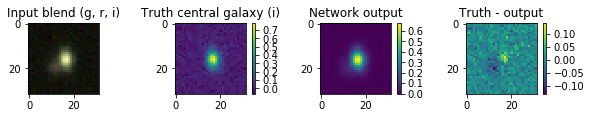

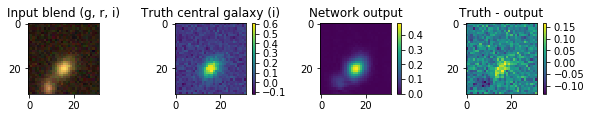

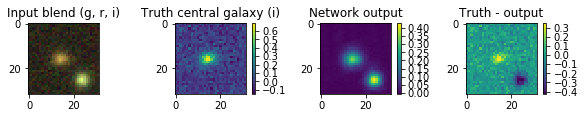

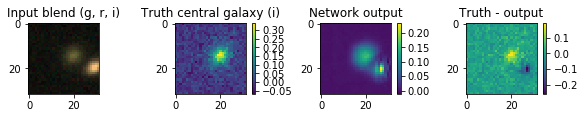

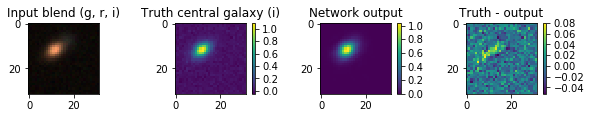

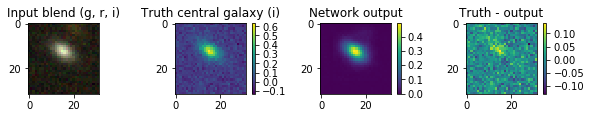

In [5]:
plt.plot(train_loss, label='training')
plt.plot(val_loss, '.', label='validation', alpha=0.5)
plt.ylabel('mean loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plot_preds(pred, X_val, Y_val)

In [12]:
from astropy.table import Table
path = '/global/projecta/projectdirs/lsst/groups/WL/projects/wl-btf/two_gal_blend_data/training_data/'
path = os.path.join(os.path.dirname(os.getcwd()), "data")
filename = os.path.join(path, 'blend_param.tab')
blend_param = Table.read(filename, format='ascii')
diff_val = save_diff_blend(pred, Y_val)

np.random.seed(0)
validation = np.where(blend_param['is_validation'] ==1)
diff_val = diff_val[blend_param['nn_id'][validation]]

IOError: [Errno 2] No such file or directory: '/global/u2/s/sowmyak/NN_blend/data/blend_param.tab'

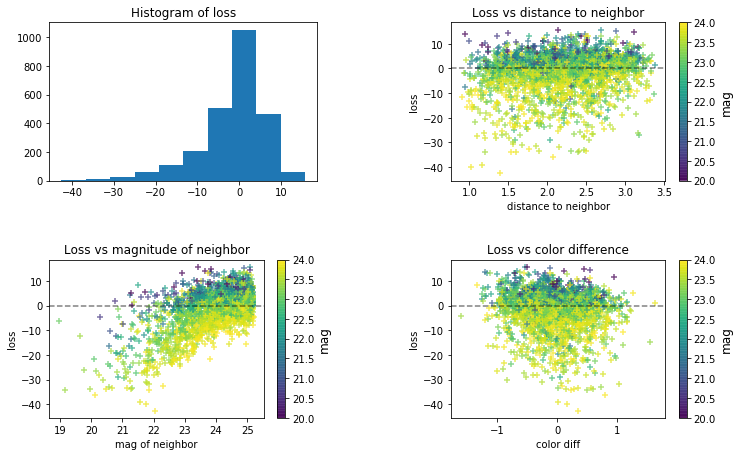

In [8]:
c = blend_param['ab_mag'][validation]

plt.figure(figsize=[12, 16])
plt.subplot(4, 2, 1)
plt.subplots_adjust(wspace = 0.5)
plt.subplots_adjust(hspace = 0.5)
plt.hist(diff_val)
plt.title("Histogram of loss")
plt.subplot(4, 2, 2)
plt.scatter(blend_param[validation]['distance_neighbor'], diff_val,
            c=c, vmin=20, vmax=24, alpha=0.7, marker='+')
cbar = plt.colorbar()
cbar.set_label(label='mag',size=12)
plt.title("Loss vs distance to neighbor")
plt.xlabel('distance to neighbor')
plt.axhline(0, linestyle='--', color='k', alpha=0.5)
plt.ylabel('loss')
plt.subplot(4, 2, 3)
plt.scatter(blend_param[validation]['mag_neighbor'], diff_val,
           c=c, vmin=20, vmax=24, alpha=0.7, marker='+')
cbar = plt.colorbar()
cbar.set_label(label='mag',size=12)
plt.title("Loss vs magnitude of neighbor")
plt.xlabel('mag of neighbor')
plt.ylabel('loss')
plt.axhline(0, linestyle='--', color='k', alpha=0.5)
plt.subplot(4, 2, 4)
plt.scatter(blend_param['color_neighbor'][validation] - blend_param['ri_color'][validation],
            diff_val, c=c, vmin=20, vmax=24, alpha=0.7, marker='+')
cbar = plt.colorbar()
cbar.set_label(label='mag',size=12)
plt.title("Loss vs color difference")
plt.xlabel('color diff')
plt.ylabel('loss')
plt.axhline(0, linestyle='--', color='k', alpha=0.5)
plt.show()

(array([  2.00000000e+00,   1.00000000e+01,   1.65000000e+02,
          1.09600000e+03,   4.63100000e+03,   1.19310000e+04,
          5.79600000e+03,   1.21500000e+03,   1.46000000e+02,
          8.00000000e+00]),
 array([-7.21875381, -5.73913841, -4.25952301, -2.77990761, -1.30029221,
         0.1793232 ,  1.6589386 ,  3.138554  ,  4.6181694 ,  6.09778481,
         7.57740021]),
 <a list of 10 Patch objects>)

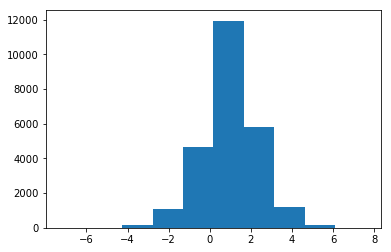

In [22]:
plt.hist(blend_param['mag_neighbor']-blend_param['ab_mag'])

In [5]:
import tensorflow as tf

In [ ]:
in_shape = input_layer.get_shape().as_list()

In [6]:
tf.nn.conv2d_transpose?

In [3]:
run_ident = "test0.0005"
model = utils.CNN_deblender(run_ident=run_ident, config=False, num_cnn_layers=6)

path = os.path.join(os.path.dirname(os.getcwd()), "outputs",
                    "models", run_ident)
fname = os.path.join(path, "model")
model.restore(fname)

Initializing multi_layer_model
Conv layer in 
[None, 32, 32, 3]
Conv layer 0 
[None, 28, 28, 4]
Conv layer 1 
[None, 26, 26, 8]
Conv layer 2 
[None, 24, 24, 16]
Conv layer 3 
[None, 22, 22, 32]
Conv layer 4 
[None, 20, 20, 64]
Deconv layer 0 
[None, 18, 18, 128]
[3, 3, 32, 128]
[None, 18, 18, 128]
Deconv layer 1 
[None, None, None, 64]


TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [3]:
def load_data(filename):
    train_data = np.load(filename)
    X_train = train_data['X_train']
    Y_train = train_data['Y_train']
    X_val = train_data['X_val']
    Y_val = train_data['Y_val']
    return X_train, Y_train, X_val, Y_val

path = '/global/cscratch1/sd/sowmyak/training_data'
filename = os.path.join(path, 'stamps.npz')
X_train, Y_train, X_val, Y_val = load_data(filename)

In [5]:
feed_dict = {model.X: X_val,
             model.y: Y_val,
             model.is_training: False}
pred = model.y_out.eval(session=model.sess, feed_dict=feed_dict)

In [6]:
def get_individual_loss(y, y_out):
    """Returns loss of each object
    Keyword Arguments:
        y     -- True isolated galaxy image as numpy array
        y_out -- Output of net as numpy array
    Returns
        L2 loss for each galaxy
    """
    diff = np.subtract(y, y_out)**2
    loss = diff.sum(axis=3).sum(axis=1).sum(axis=1)
    return loss / 2.


ind_loss = get_individual_loss(Y_val, pred)

In [7]:
def plot_preds(pred, X_val, Y_val, val_loss):
    for num in range(0, 30):
        plt.figure(figsize=[10, 6])
        plt.subplot(5, 5, 1)
        color_im = get_rgb(X_val[num, :, :, :])
        plt.imshow(color_im, norm=LogNorm(vmin=0,
                                          vmax=np.max(color_im) - 3 * np.std(color_im)))
        plt.title('Input blend (g, r, i)')
        plt.subplot(5, 5, 2)
        plt.imshow(X_val[num, :, :, 0])
        plt.colorbar()
        plt.title('Input blend (i)')
        plt.subplot(5, 5, 3)
        plt.imshow(Y_val[num, :, :, 0])
        plt.title('Truth central galaxy (i)')
        plt.colorbar()
        plt.subplot(5, 5, 4)
        plt.imshow(pred[num, :, :, 0])
        plt.colorbar()
        plt.title('Network output')
        plt.subplot(5, 5, 5)
        plt.imshow(Y_val[num, :, :, 0] - pred[num, :, :, 0])
        plt.colorbar()
        plt.title('Truth - output, loss: {}'.format(val_loss[num]))
        plt.show()

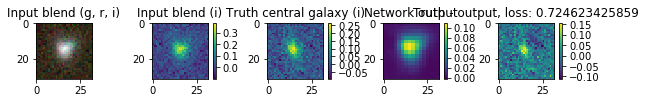

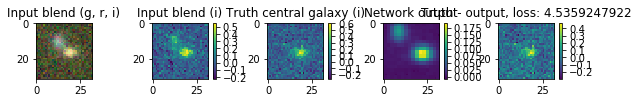

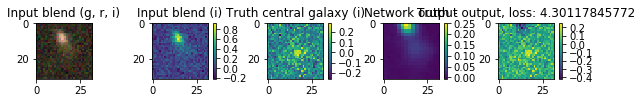

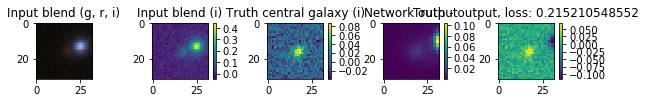

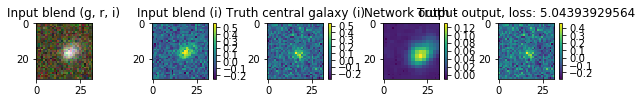

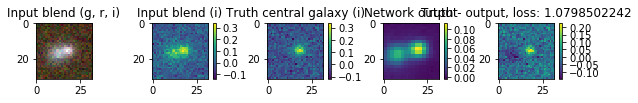

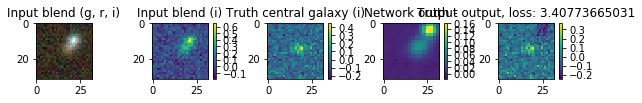

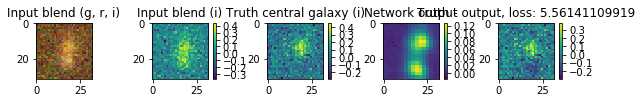

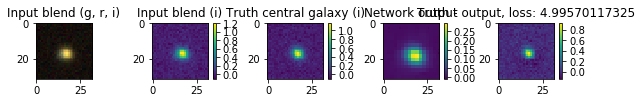

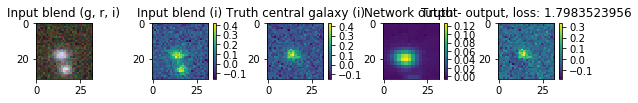

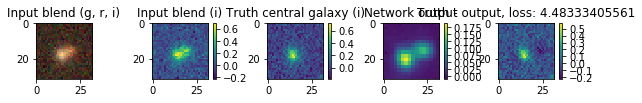

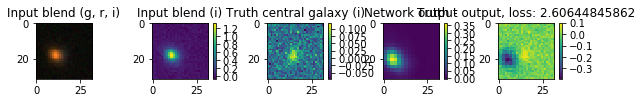

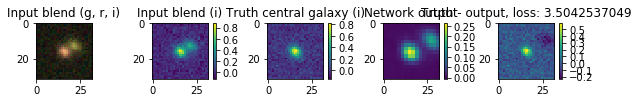

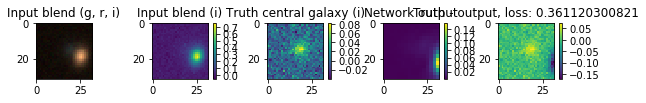

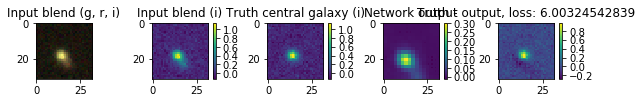

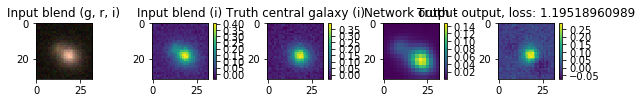

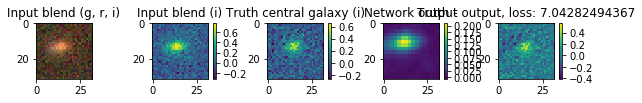

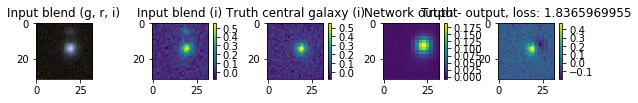

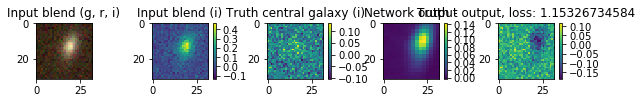

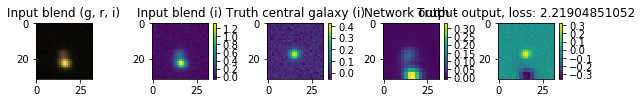

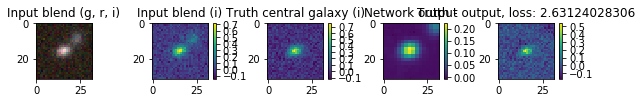

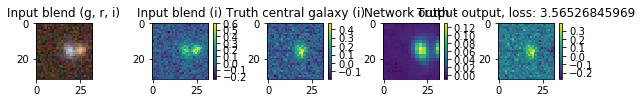

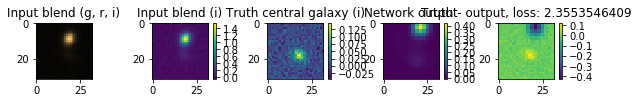

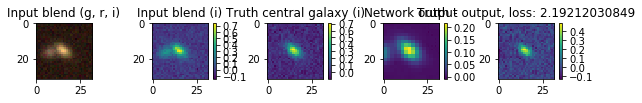

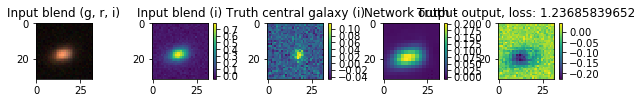

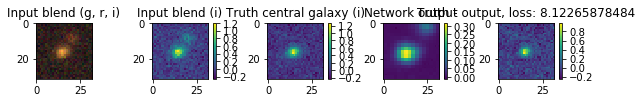

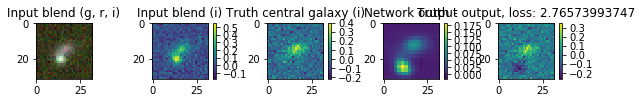

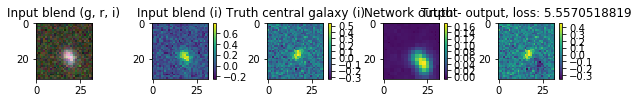

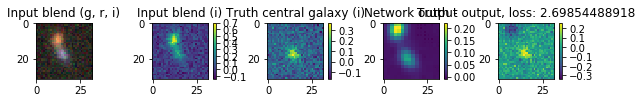

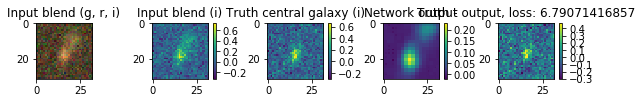

In [8]:

from matplotlib.colors import LogNorm
def get_rgb(im):
    min_val = [np.min(im[:,:,i]) for i in range(3)]
    new_im = [im[:,:,i] + np.abs(min_val[i]) for i in range(3)]
    norm = np.max(new_im)
    new_im = [new_im[i].T/norm * 255 for i in range(3)]
    new_im = np.array(new_im, dtype='u1')
    return new_im.T

plot_preds(pred, X_val, Y_val, ind_loss)

In [ ]:
e.

In [15]:
e = range(5)

In [14]:
range(4,-1, -1)

[4, 3, 2, 1, 0]

In [19]:
run_ident = "test30.0005"
model3 = utils.CNN_deblender(run_ident=run_ident, config=False, num_cnn_layers=6,learning_rate=5e-4)

path = os.path.join(os.path.dirname(os.getcwd()), "outputs",
                    "models", run_ident)
fname = os.path.join(path, "model")
model3.restore(fname)

Initializing simple model4
INFO:tensorflow:Restoring parameters from /global/u2/s/sowmyak/NN_blend/outputs/models/test30.0005/model


NotFoundError: Key conv_layer5/BatchNorm/moving_var not found in checkpoint
	 [[Node: save/RestoreV2_77 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_77/tensor_names, save/RestoreV2_77/shape_and_slices)]]

Caused by op u'save/RestoreV2_77', defined at:
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/global/common/cori/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-2262826e2173>", line 7, in <module>
    model3.restore(fname)
  File "/global/u2/s/sowmyak/NN_blend/scripts/basic_net_utils.py", line 327, in restore
    self.y: Y_test,
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1140, in __init__
    self.build()
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1172, in build
    filename=self._filename)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 688, in build
    restore_sequentially, reshape)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 663, in restore_v2
    dtypes=dtypes, name=name)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/common/software/python/2.7-anaconda-4.4/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key conv_layer5/BatchNorm/moving_var not found in checkpoint
	 [[Node: save/RestoreV2_77 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_77/tensor_names, save/RestoreV2_77/shape_and_slices)]]


In [ ]:
feed_dict = {model2.X: X_val,
             model2.y: Y_val,
             model2.is_training: False}
pred2 = model2.y_out.eval(session=model2.sess, feed_dict=feed_dict)
ind_loss2 = get_individual_loss(Y_val, pred2)
plot_preds(pred, X_val, Y_val, ind_loss)